In [ ]:
import pandas as pd
import numpy as np
import warnings
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
warnings.filterwarnings('ignore')
from dataclasses import dataclass
from typing import Tuple

# Market Making model with Linear utility and inventory penalty


Value Function:
$$
H(t, x, s, q) = 𝔼_{t} \left[X_T + q_TS_T + h(T, q_T) - φ \int_{t}^{T} {e^{-(T-t)}}.{q_t}^{2}dt \ | \ X_t \right]
$$


Terminal Condition:
$$
h(T, q_T) = -\gamma.q_T^2
$$

Problem Formulation fro the Market Maker, using the DPP:
$$
H(t,x,s,q) = max_{δ^{-},δ^{+}}𝔼_t[H(T,x,s,q)] = max_{δ^{-},δ^{+}}𝔼_t[H(t+dt,x+dx,s+ds,q+dq) + L]
$$

Applying taylor expansion and simplifying,
$$
\begin{align}
           0 &= max_{δ^{-},δ^{+}}𝔼[∂_{t}H.dt + ∂_{s}H.ds +.5 ∂_{ss}H.(ds)^2 \\ & + A(δ^{+})dt.[H(t,x+s+δ^{+},s,q-1)-H(t,x,s,q)] \\ & + A(δ^{-})dt.[H(t,x-s+δ^{-},s,q+1)-H(t,x,s,q)]
           \\ & - φ{e^{-(T-t)}}.{q_t}^{2}.dt]
\end{align}
$$
Simplifying
$$
\begin{align}
          0 &= max_{δ^{-},δ^{+}} [ ∂_{t}H +  .5σ^2∂_{ss}H ++ A(δ^{+})dt.[H(t,x+s+δ^{+},s,q-1)-H(t,x,s,q)] \\ & + A(δ^{-})dt.[H(t,x-s+δ^{-},s,q+1)-H(t,x,s,q)] - φ{e^{-(T-t)}}.{q_t}^{2} ]
\end{align}
$$

HJB:

$$
\begin{align}
0 &= ∂_th(t,q) + max_{δ^{+},δ^{-}} \{ λ_0^+.e^{-k(δ^{+})}.[δ^{+} + h(t,q_t - 1) - h(t, q_t)] + λ_0^-.e^{-k(δ^{-})}.[δ^{-} + h(t,q_t + 1) - h(t, q_t)] \}
\\ & - φ{e^{-(T-t)}}.{q_t}^{2}
\end{align}
$$

Here a square function for the instantaneous penalty penalizes large inventory and exponential decay penailizes inventory more near end of time, allowing to take more risks now.

**Parameters**

In [ ]:
q_min = -25 # largest short position posible
q_max = 25 # largest long position possible

T = 1 # Maximum time you want to hold on to your inventory (minutes)
dt = .01 # breaking down each second to 100 ms
n = 60/dt
T_range = int(T*n)

gamma = .001
phi = 0.001
lambda_plus = 100 # arrival rate of buy orders per second
lambda_minus = 100 # arrival rate of sell orders per second
sigma = .25 # volatility

k = 50 # arrival rate decay factor of buy orders
k_minus = 50 # arrival rate decay factor of sell orders

h = np.zeros((T_range, q_max - q_min + 1))
d1 = np.zeros((T_range, q_max - q_min + 1))
d2 = np.zeros((T_range, q_max - q_min + 1))

**Solving the HJB**

In [ ]:
# Inititialize h(T,qT)
for q in range(q_min, q_max+1):
  q_id = q - q_min
  h[0,q_id] = -gamma*np.power(q,2)
  d1[0,q_id] = 0
  d2[0,q_id] = 0

for t in range(1, T_range):
  for q in range(q_min, q_max+1):
    q_id = q - q_min
    # calculate optimal delta and d
    if q != q_min:
      d1[t, q_id] = 1/k - (h[t-1, q_id-1] - h[t-1, q_id])

    if q != q_max:
      d2[t,q_id] = 1/k - (h[t-1, q_id+1] - h[t-1, q_id])

    # caluculate value function using DPP principles
    a = 0; b = 0
    if q!=q_max:
      a = lambda_minus*np.exp(-k*d2[t,q_id])/k
    if q!=q_min:
      b = lambda_plus*np.exp(-k*(d1[t,q_id]))/k

    h[t,q_id] = h[t-1,q_id] + (a + b - phi*np.exp(-(t)*dt)*np.power(q,2))*dt

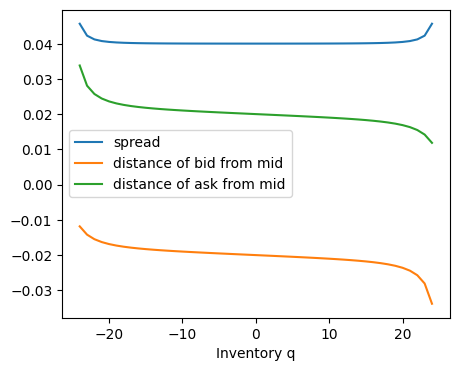

In [ ]:
t = 599
f, ax = plt.subplots(figsize=[5, 4])
ax.plot(np.arange(q_min+1, q_max), d1[t,1:-1]+d2[t,1:-1], label = "spread")
ax.plot(np.arange(q_min+1, q_max), -d2[t,1:-1], label = "distance of bid from mid")
ax.plot(np.arange(q_min+1, q_max), d1[t,1:-1], label = "distance of ask from mid")
ax.set_xlabel("Inventory q")  # Optional: label for x-axis
ax.legend()
# ax.show()

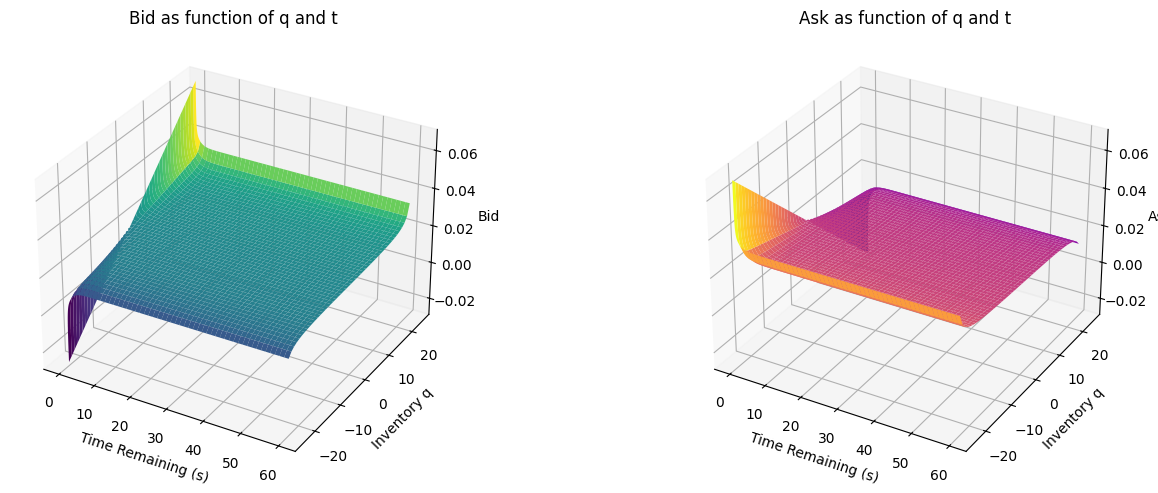

In [ ]:
# Assuming h, d1, d2, q_min, q_max, T_range are already defined
q_range = np.arange(q_min+1, q_max)
t_range = np.arange(0, T_range-1)*dt
Q, T = np.meshgrid(q_range, t_range)  # Create meshgrid for plotting

# Plot bid
fig = plt.figure(figsize=(15, 5))
ax1 = fig.add_subplot(121, projection='3d')
ax1.plot_surface(T, Q, d2[1:,1:-1], cmap='viridis')
ax1.set_title('Bid as function of q and t')
ax1.set_xlabel('Time Remaining (s)')
ax1.set_ylabel('Inventory q')
ax1.set_zlabel('Bid')

# Plot ask
ax2 = fig.add_subplot(122, projection='3d')
ax2.plot_surface(T, Q, d1[1:,1:-1], cmap='plasma')
ax2.set_title('Ask as function of q and t')
ax2.set_xlabel('Time Remaining (s)')
ax2.set_ylabel('Inventory q')
ax2.set_zlabel('Ask')

plt.tight_layout()
plt.show()

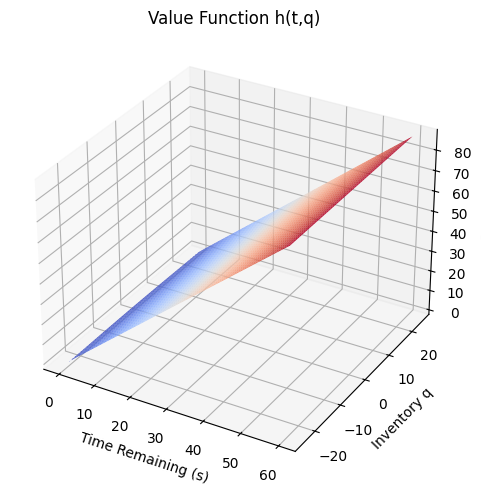

In [ ]:
# Plot Value Function
fig = plt.figure(figsize=(15, 5))
ax3 = fig.add_subplot(111, projection='3d')
ax3.plot_surface(T, Q, h[1:,1:-1], cmap='coolwarm')
ax3.set_title('Value Function h(t,q)')
ax3.set_xlabel('Time Remaining (s)')
ax3.set_ylabel('Inventory q')
ax3.set_zlabel('Spread')

plt.tight_layout()
plt.show()

# AS Market Making model (Exponential utility function)


In [ ]:
q_min = -10  # Min inventory
q_max = 10   # Max inventory
q_range = np.arange(q_min, q_max+1)

# Define parameters
T = 5/60 # Maximum time you want to hold on to your inventory (minutes)
dt = .0001 # breaking down each second to 100 ms
n = 60/dt
T_range = int(T*n)

S0 = 10  # Current Stock Price
N_s = 20  # Number of space steps
ds = .01 # analysis of bid ask on +/- 5% of stock price
S = np.linspace(S0 - .5*N_s*ds, S0 + .5*N_s*ds, N_s+1)  # Range around S0

lambda_plus = 100 # arrival rate of buy orders per second
lambda_minus = 100 # arrival rate of sell orders per second

gamma = .001
phi = 0.001
sigma = 0.25
k = 50 # arrival rate decay factor of buy orders

Theta = np.zeros((len(S), T_range+1, len(q_range)))
d1 = np.zeros((len(S), T_range+1, len(q_range)))
d2 = np.zeros((len(S), T_range+1, len(q_range)))

21


In [ ]:
# Initialize
for s in range(len(S)):
  for q_id in range(len(q_range)):
    Theta[s, 0, q_id] = q_range[q_id] * S[s]

# Iterate:
for t in range(1, T_range):
  for s in range(0, len(S)):
    for q_id in range(len(q_range)):
      q = q_range[q_id]

      # Calculate optimal delta and d
      if q_id != 0:  # Avoid out-of-bounds error
        d1[s, t, q_id] = 1/gamma * np.log(k/(k-gamma)) - S[s] - (Theta[s, t-1, q_id-1] - Theta[s, t-1, q_id])

      if q_id != len(q_range) - 1:  # Avoid out-of-bounds error
        d2[s, t, q_id] = 1/gamma * np.log(k/(k-gamma))  + S[s] - (Theta[s, t-1, q_id+1] - Theta[s, t-1, q_id])

      # Calculate value function using DPP principle
      a = 0; b = 0
      if q_id != len(q_range) - 1:
        a = -lambda_minus * np.exp(-k * d2[s, t, q_id])*gamma / (k-gamma)
      if q_id != 0:
        b = -lambda_plus * np.exp(-k * d1[s, t, q_id]) *gamma / (k-gamma)

      if s == 0 or s == len(S) - 1:
        term1 = 0
      else:
        term1 = 0.5 * (sigma**2) * ((Theta[s+1, t-1, q_id] - 2 * Theta[s, t-1, q_id] + Theta[s-1, t-1, q_id]) / ds**2)

      if s!=0: # take backward derivative
        term2 = -0.5 * (sigma**2) * gamma * ((Theta[s, t-1, q_id] - Theta[s-1, t-1, q_id]) / ds)**2
      else: # take forward derivative if backward doesnt exist
        term2 = -0.5 * (sigma**2) * gamma * ((Theta[s+1, t-1, q_id] - Theta[s, t-1, q_id]) / ds)**2

      # Update Theta
      if q_id == 0 or q_id == len(q_range) - 1:
        continue
      else:
        Theta[s, t, q_id] = Theta[s, t-1, q_id] + dt * (term1 + term2 + a + b - phi*np.exp(-(T_range-t)*dt)*np.power(q,2))

    # theta for boundary set carefully to ensure convergence
    Theta[s, t, 0] = Theta[s, t, 1] - S[s]
    Theta[s, t, -1] = Theta[s, t, -2] + S[s]

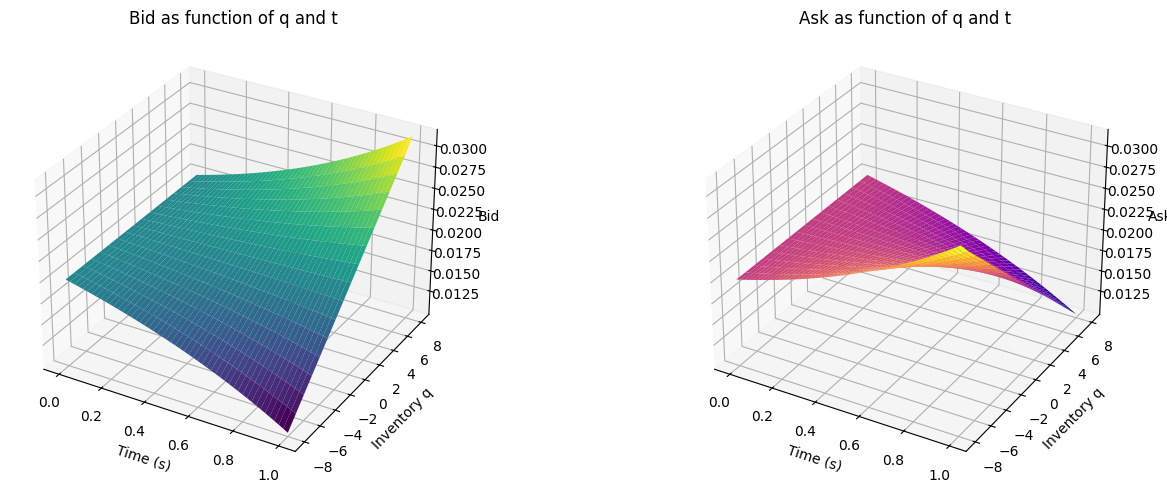

In [ ]:
# Create a range for q and t
q_range_for_plot = q_range[2:-2]
t_range_for_plot = np.arange(0, T_range-1)  # Time range for plotting
S_mid = int(N_s/2)

# Create meshgrid for q and t
Q, T = np.meshgrid(q_range_for_plot, t_range_for_plot)

# Initialize the plot
fig = plt.figure(figsize=(15, 5))

# Plot d2 (Bid) surface plot
ax1 = fig.add_subplot(121, projection='3d')
ax1.plot_surface(T*dt, Q, d2[S_mid,1:-1,2:-2], cmap='viridis')  # Adjust slicing as needed
ax1.set_title('Bid as function of q and t')
ax1.set_xlabel('Time (s)')
ax1.set_ylabel('Inventory q')
ax1.set_zlabel('Bid')

# Plot d1 (Ask) surface plot
ax2 = fig.add_subplot(122, projection='3d')
ax2.plot_surface(T*dt, Q, d1[S_mid,1:-1,2:-2], cmap='plasma')  # Adjust slicing as needed
ax2.set_title('Ask as function of q and t')
ax2.set_xlabel('Time (s)')
ax2.set_ylabel('Inventory q')
ax2.set_zlabel('Ask')

plt.tight_layout()
plt.show()